In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

#Configuration for the font and style in the graphics
params = {
        'font.family': 'serif',
        'font.serif': ['STIXGeneral', 'Times New Roman'],
        'font.size': 14,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'figure.figsize': (6.4, 4.8),
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight'
    }
    
plt.rcParams.update(params)

In [ ]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

In [ ]:
#Lines from the file of Clean lines
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Visible range\Data\Nave Fe I list_VIS.xlsx", skiprows=10, usecols=[0], names=['Nave list'])

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
613,10425.8870
614,10426.6020
615,10535.1220
616,10580.0390


In [18]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)

In [19]:
closer_lines_VIS = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

In [6]:
#Localize the line and save the width for each one
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

local_points = width_minimums(closer_lines,raw_data,0.05) #The range is 0.05mA

In [ ]:
def Uncertainty(index):
    windows = []
    for i in index:
        wave_local = closer_lines_VIS['min_wave'].loc[i]
        steps = np.arange(0.01,0.2,0.001)
        wind = []
        for each in steps:
            window = raw_data[raw_data['Wave A'].between(wave_local-each, wave_local+each, inclusive='neither')]
            wind.append(window)
        windows.append(wind)
    return windows

unc,window = Uncertainty([0,172,235,378,420,538])

In [7]:
def arrange_lambda(wave_index, local_points):

    data = local_points[wave_index]

    down = min(data['Wave A'].index)
    up = max(data['Wave A'].index)

    new_data= []

    while len(data)>10:
        data = data.loc[down:up]
        new_data.append(data)

        #Update the cycle
        up -= 1
        down += 1
        
    return new_data

new_local_points = arrange_lambda(0, local_points)

In [8]:
def Fit_derivates(local_points,wave):
    values = []
    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values, taking into account the number of points defined on the covariance matrix
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))*(const.c/lamda_obs[0])

            #Evaluate the second and third derivate in the wavelength observed. Re-scalated the coefficients
            d2 = (poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2)) 
            d3 = (Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) )) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/wave) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, Core curvature, Bisector slope, convective blueshift,line depth
            values.append(pd.DataFrame([[wave,lamda_obs[0],lamda_obs[1],velocity,d2*(lamda_obs[0]**2),d3*(const.c/lamda_obs[0]),blueshift,1-lamda_obs[1],len(local_points[i]),wave_std]])) 


    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","Core curvature","Bisector slope","Blueshift",'Line Depth','Points','Wave std']

    return Values

# Values = Fit_derivates(new_local_points,closer_lines['Fe line'].iloc[0])

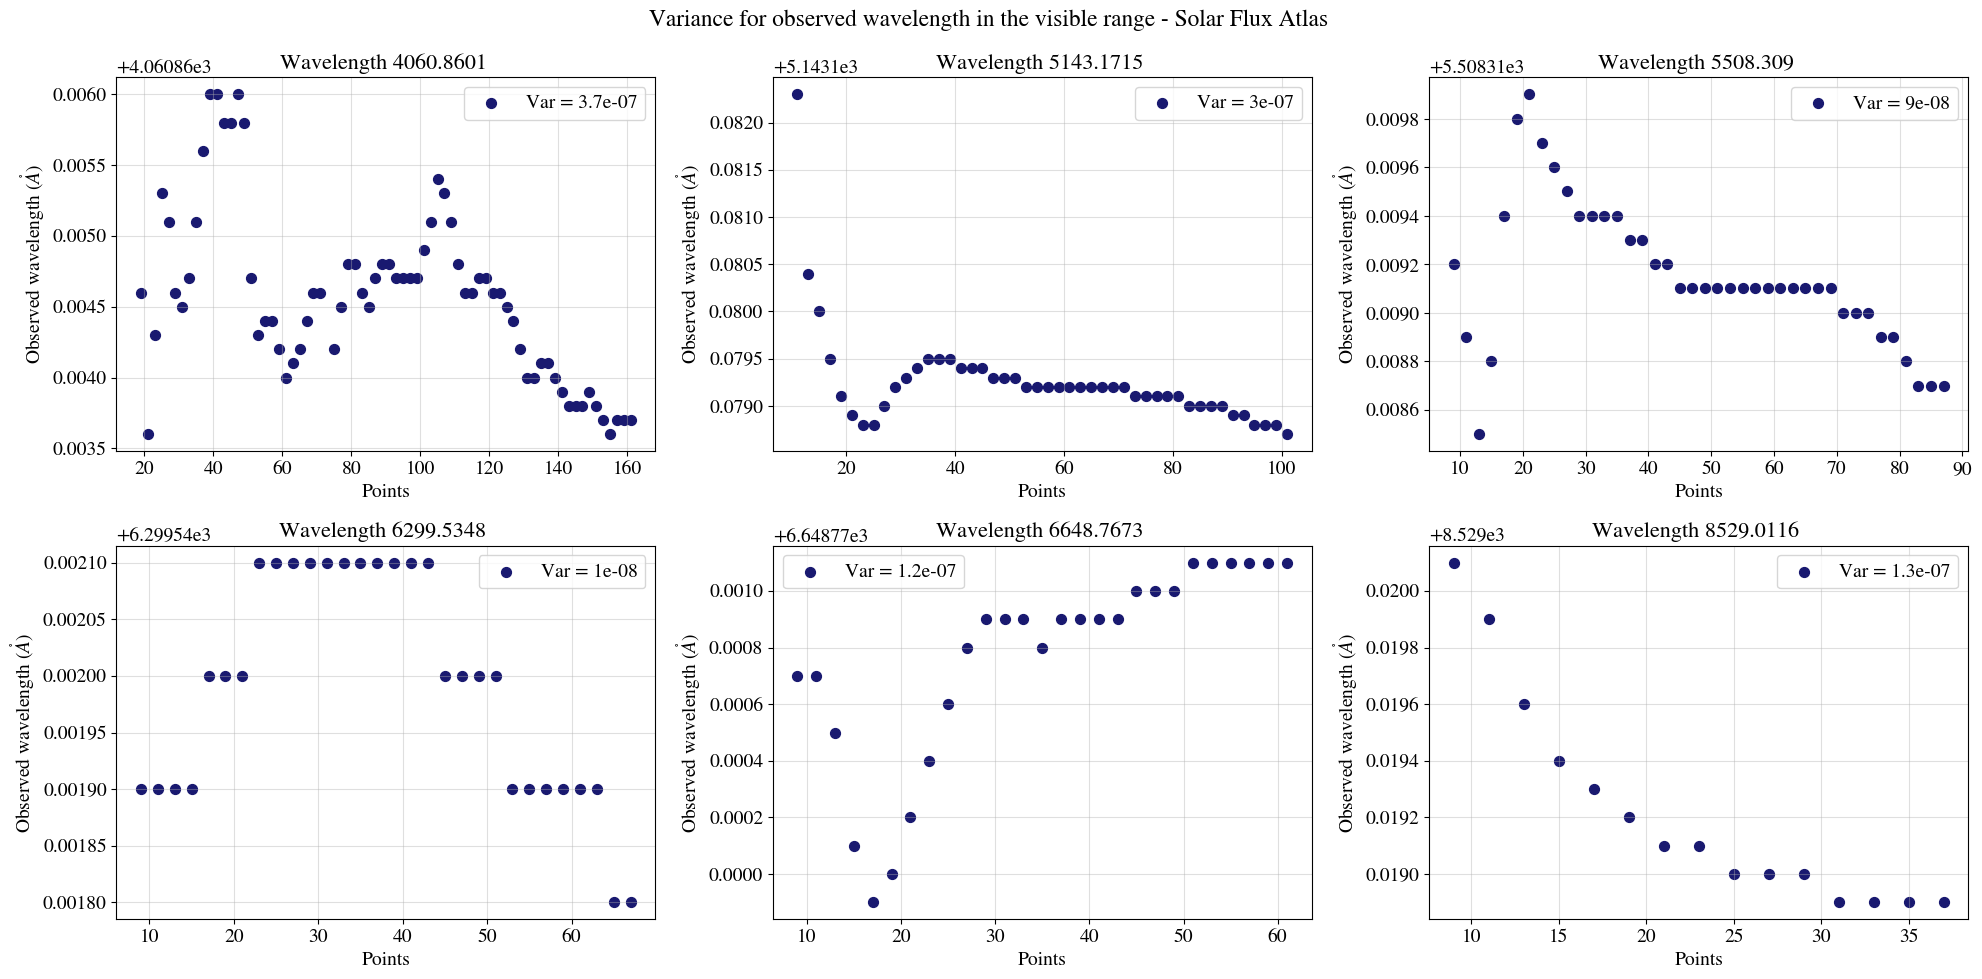

In [9]:
list_index = [0,172,235,378,420,538]

fig5, axes = plt.subplots(2,3,figsize=(20,10))
fig5.suptitle('Variance for observed wavelength in the visible range - Solar Flux Atlas')
axes = axes.flatten()

#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):

    new_local_points = arrange_lambda(list_index[i], local_points)
    Values = Fit_derivates(new_local_points,closer_lines['Fe line'].iloc[list_index[i]])
    Values = Values[Values['Velocity']<700 ]
    Values = Values[Values['Velocity']>-700 ]
    # Values = Values[Values['Points']>60 ]
    variance = np.var(Values['Observed wavelength'])

    ax.scatter(Values['Points'],Values["Observed wavelength"],label = 'Var = {}'.format(round(variance,8)),c='midnightblue',s=50) 

    ax.set_title(r'Wavelength {} '.format(Values["Emitted wavelength"].iloc[0]))   
    ax.set_ylabel(r'Observed wavelength $(\mathring{A})$')
    ax.set_xlabel(r'Points')
    ax.grid(alpha=0.4)
    ax.legend()

fig5.tight_layout()
# fig5.savefig('variance VIS')

Now, check the variance of the mean altering the window of the line

In [ ]:
def Uncertainty(index):
    list_wave = []
    windows = []
    for i in index:
        list_statistics =[]
        wave_local = closer_lines['min_wave'].loc[i]
        steps = np.arange(0.01,0.2,0.001)
        wind = []
        for each in steps:
            window = raw_data[raw_data['Wave A'].between(wave_local-each, wave_local+each, inclusive='neither')]
            data_wave = window['Wave A']
            wave_std = np.std(data_wave)

            list_statistics.append(pd.DataFrame({'Std': wave_std},index=[each]))
            wind.append(window)

        list_wave.append(pd.concat(list_statistics,axis=0).dropna())
        windows.append(wind)
    return list_wave,windows

unc,window = Uncertainty([0,172,235,378,420,538])

In [17]:
window[0]

,Wave (cm),nFlux,rFlux,Wave A
19829,24625.399192,0.379672,0.001861,4060.847876
19830,24625.395426,0.365276,0.001876,4060.848497
19831,24625.391659,0.363447,0.001854,4060.849118
19832,24625.387893,0.358690,0.001807,4060.849739
19833,24625.384126,0.361602,0.001776,4060.850360
19834,24625.380359,0.379956,0.001754,4060.850981
19835,24625.376593,0.387991,0.001719,4060.851603
19836,24625.372826,0.362023,0.001702,4060.852224
19837,24625.369060,0.318430,0.001733,4060.852845
19838,24625.365293,0.297565,0.001783,4060.853466


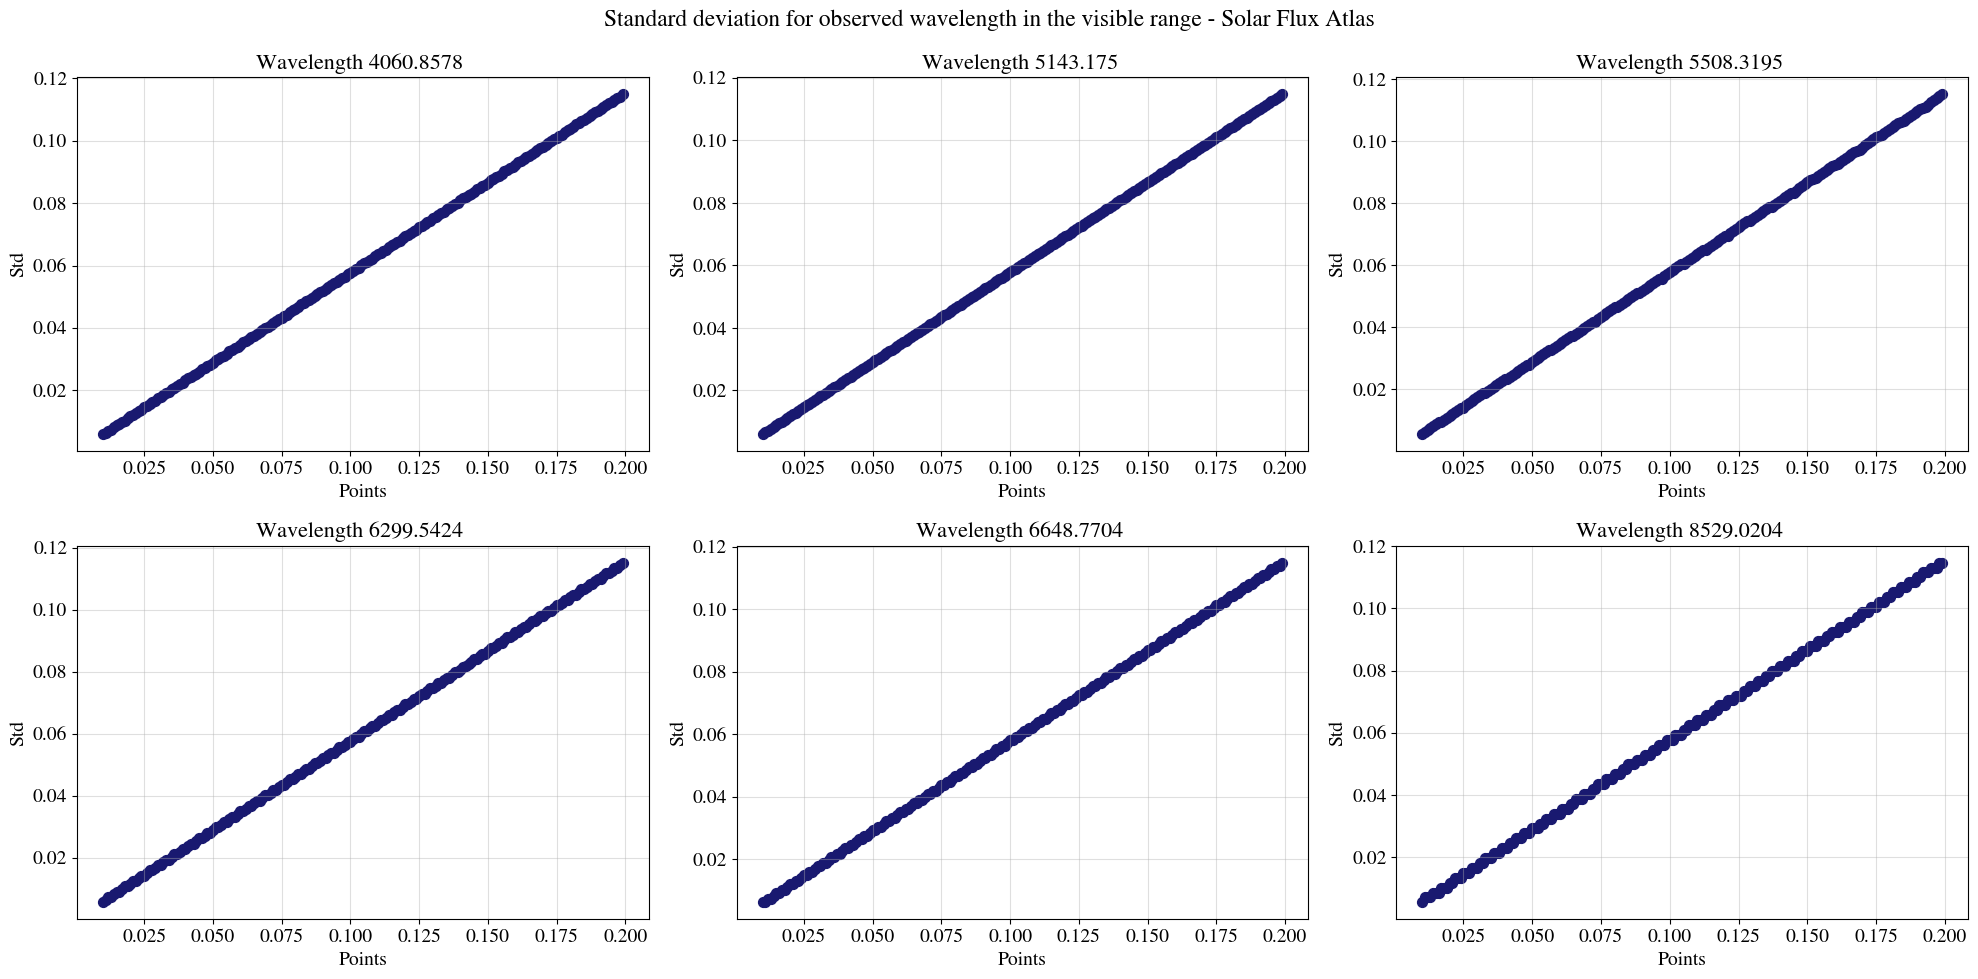

In [11]:
fig5, axes = plt.subplots(2,3,figsize=(20,10))
fig5.suptitle('Standard deviation for observed wavelength in the visible range - Solar Flux Atlas')
axes = axes.flatten()
l=[0,172,235,378,420,538]
#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):

    ax.scatter(unc[i].index,unc[i]["Std"],c='midnightblue',s=50) 

    ax.set_title(r'Wavelength {} '.format(round(closer_lines['min_wave'].loc[l[i]],4)))   
    ax.set_ylabel(r'Std')
    ax.set_xlabel(r'Points')
    ax.grid(alpha=0.4)

fig5.tight_layout()

TypeError: Uncertainty() takes 1 positional argument but 2 were given

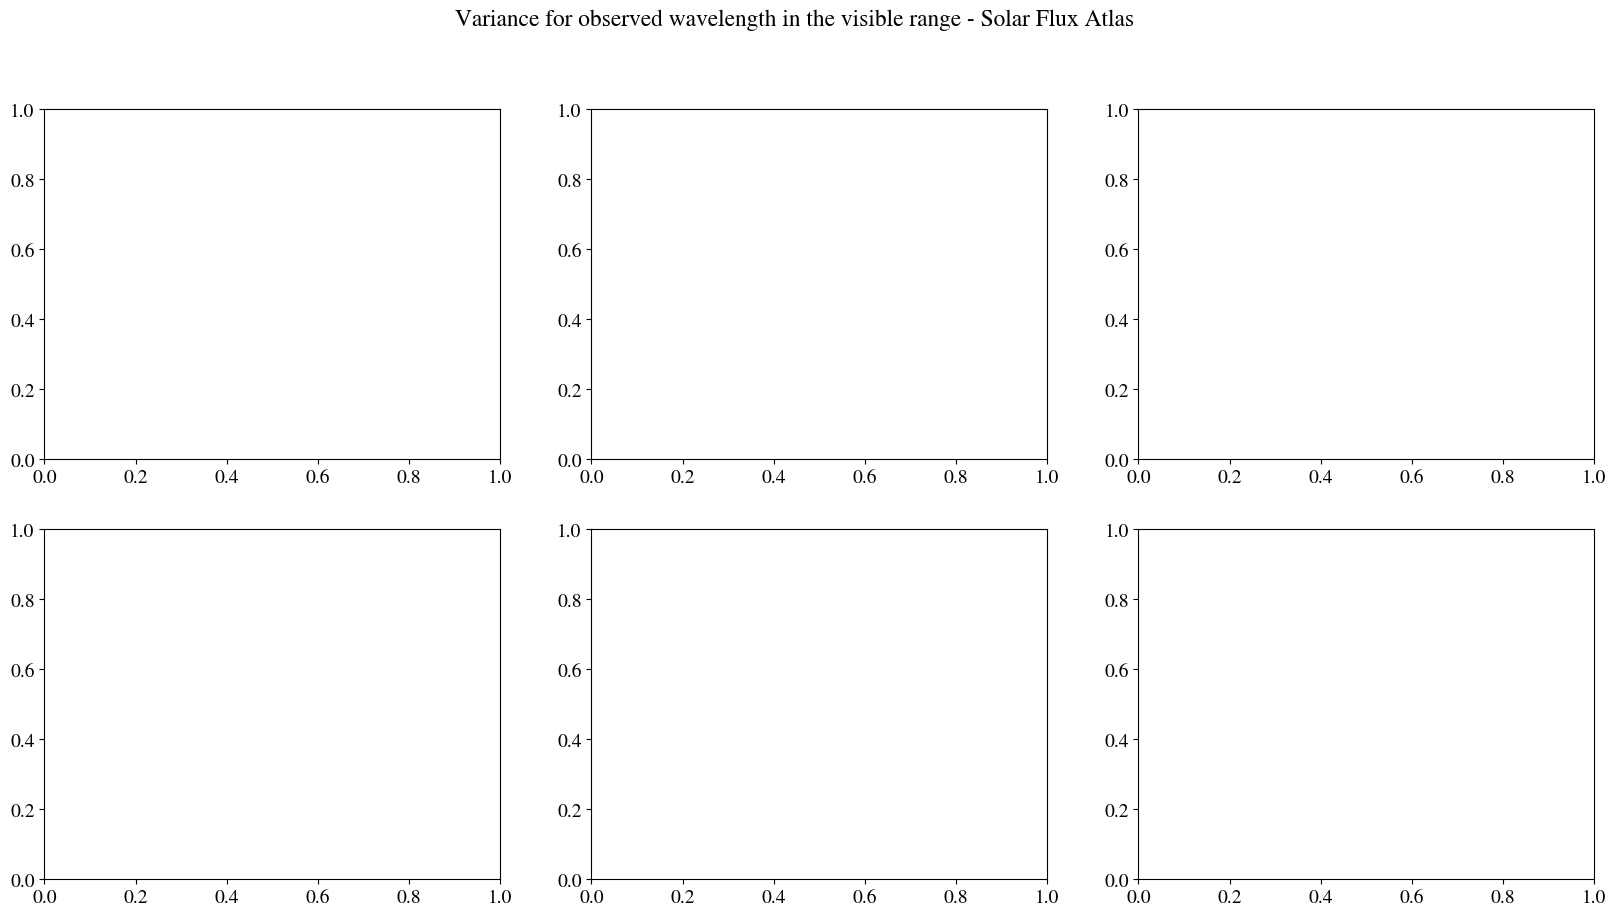

In [ ]:
list_index = [0,172,235,378,420,538]

fig5, axes = plt.subplots(2,3,figsize=(20,10))
fig5.suptitle('Variance for observed wavelength in the visible range - Solar Flux Atlas')
axes = axes.flatten()

#Plot the cuadratic fit for each color
for i, ax in enumerate(axes):

    new_local_points = arrange_lambda(list_index[i], window[i])
    Values = Fit_derivates(new_local_points,closer_lines['Fe line'].iloc[list_index[i]])
    # Values = Values[Values['Velocity']<700 ]
    # Values = Values[Values['Velocity']>-700 ]
    # Values = Values[Values['Points']>60 ]
    variance = np.var(Values['Observed wavelength'])

    ax.scatter(Values['Wave std'],np.abs(Values["Observed wavelength"] - Values["Emitted wavelength"].iloc[0]),label = 'Var = {}'.format(round(variance,8)),c='midnightblue',s=50) 
    # ax.scatter(Values['Points'].iloc[np.argmin(np.abs(Values["Observed wavelength"] - Values["Emitted wavelength"].iloc[0]))], 
            #    min(np.abs(Values["Observed wavelength"] - Values["Emitted wavelength"].iloc[0])),c='red',s=50)
    ax.set_title(r'Wavelength {} '.format(Values["Emitted wavelength"].iloc[0]))   
    ax.set_ylabel(r'Observed wavelength $(\mathring{A})$')
    ax.set_xlabel(r'Points')
    ax.grid(alpha=0.4)
    ax.legend()

fig5.tight_layout()
# fig5.savefig('variance VIS')

### Near infrared range

In [ ]:
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\NIR_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

In [ ]:
#Lines from the file of Clean lines
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\Nave Fe I_NIR.xlsx", skiprows=10, usecols=[0], names=['Nave list'])

In [ ]:
closer_lines_NIR = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])